In [ ]:
!pip install open_clip_torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.6 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import open_clip
import torchvision.models as models
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import timm


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("awsaf49/coco-2017-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'coco-2017-dataset' dataset.
Path to dataset files: /kaggle/input/coco-2017-dataset


Teacher

In [ ]:
import torch
import open_clip

# 1. Setup Device
device = "cuda" if torch.cuda.is_available() else "cpu"

print("🦖 Instantiating Teacher (ViT-B-16)...")

# 2. Load Model
# We try LAION-2B first (standard for modern reproduction), fallback to OpenAI if needed
try:
    teacher, _, preprocess = open_clip.create_model_and_transforms('ViT-B-16', pretrained='laion2b_s34b_b88k', device=device)
    print("   ↳ Weights: LAION-2B (Loaded Successfully)")
except:
    teacher, _, preprocess = open_clip.create_model_and_transforms('ViT-B-16', pretrained='openai', device=device)
    print("   ↳ Weights: OpenAI (Fallback Loaded)")

# 3. Freeze Teacher (Crucial for KD)
teacher.eval()
for param in teacher.parameters():
    param.requires_grad = False

# 4. Utilities
tokenizer = open_clip.get_tokenizer('ViT-B-16')

print(f"✅ Teacher variable 'teacher' is ready on {device}.")

🦖 Instantiating Teacher (ViT-B-16)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

   ↳ Weights: LAION-2B (Loaded Successfully)
✅ Teacher variable 'teacher' is ready on cuda.


Student

In [ ]:
class StudentTextTransformer(nn.Module):
    def __init__(self, vocab_size=49408, width=384, layers=12, heads=6, output_dim=512):
        super().__init__()
        self.width = width
        self.token_embedding = nn.Embedding(vocab_size, width)
        self.positional_embedding = nn.Parameter(torch.empty(77, width))

        # Use a proper Transformer (CLIP style)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=width,
            nhead=heads,
            batch_first=True,
            norm_first=True,
            activation="gelu",
            dropout=0.0 # Standard CLIP doesn't use dropout during inference/KD
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=layers)
        self.ln_final = nn.LayerNorm(width)
        self.text_projection = nn.Parameter(torch.empty(width, output_dim))

        # Register causal mask to ensure identical behavior to MobileViT run
        mask = torch.triu(torch.ones(77, 77) * float('-inf'), diagonal=1)
        self.register_buffer("mask", mask)

    def forward(self, input_ids):
        # 1. Embeddings
        x = self.token_embedding(input_ids) + self.positional_embedding

        # 2. Apply Causal Mask (Ensures same 'direction' as MobileViT transformer)
        x = self.transformer(x, mask=self.mask)

        # 3. Final Norm and Pooling
        x = self.ln_final(x)
        # Pool at the [EOT] token position
        x = x[torch.arange(x.shape[0]), input_ids.argmax(dim=-1)]
        return x @ self.text_projection

class MobileCLIPStudent(nn.Module):
    def __init__(self):
        super().__init__()
        # MobileNetV3-Small
        self.vision = models.mobilenet_v3_small(weights='IMAGENET1K_V1')
        vis_dim = self.vision.classifier[0].in_features
        self.vision.classifier = nn.Identity()
        self.visual_proj = nn.Linear(vis_dim, 512, bias=False)

        # Transformer (Ensures exact same capacity as your MobileViT text side)
        self.text = StudentTextTransformer(width=384, layers=12, heads=6)
        self.logit_scale = nn.Parameter(torch.ones([]) * 2.6592)

    def forward(self, images, input_ids):
        v = self.visual_proj(self.vision(images))
        v = v / v.norm(dim=-1, keepdim=True)

        t = self.text(input_ids)
        t = t / t.norm(dim=-1, keepdim=True)

        return v, t, self.logit_scale.exp()

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class StudentTextTransformer(nn.Module):
    def __init__(self, vocab_size=49408, width=384, layers=12, heads=6, output_dim=512):
        super().__init__()
        self.width = width
        self.token_embedding = nn.Embedding(vocab_size, width)
        self.positional_embedding = nn.Parameter(torch.empty(77, width))

        # Use a proper Transformer (CLIP style)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=width,
            nhead=heads,
            batch_first=True,
            norm_first=True,
            activation="gelu",
            dropout=0.0
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=layers)
        self.ln_final = nn.LayerNorm(width)
        self.text_projection = nn.Parameter(torch.empty(width, output_dim))

        # Register causal mask
        mask = torch.triu(torch.ones(77, 77) * float('-inf'), diagonal=1)
        self.register_buffer("mask", mask)

    def forward(self, input_ids):
        # 1. Embeddings
        x = self.token_embedding(input_ids) + self.positional_embedding

        # 2. Apply Causal Mask
        x = self.transformer(x, mask=self.mask)

        # 3. Final Norm and Pooling
        x = self.ln_final(x)
        x = x[torch.arange(x.shape[0]), input_ids.argmax(dim=-1)]
        return x @ self.text_projection

class ResNetCLIPStudent(nn.Module):
    def __init__(self, output_dim=512):
        super().__init__()
        # --- VISION BACKBONE (ResNet18) ---
        self.vision = models.resnet18(weights='IMAGENET1K_V1')

        # ResNet stores the final classifier in a layer named 'fc'.
        # We grab its input dimension (512 for ResNet18) before replacing it.
        vis_dim = self.vision.fc.in_features

        # Replace the classification head with Identity to get raw features
        self.vision.fc = nn.Identity()

        # Project from ResNet feature dimension (512) to CLIP embedding dimension (512)
        self.visual_proj = nn.Linear(vis_dim, output_dim, bias=False)

        # --- TEXT BACKBONE ---
        self.text = StudentTextTransformer(width=384, layers=12, heads=6, output_dim=output_dim)

        # Learnable Temperature
        self.logit_scale = nn.Parameter(torch.ones([]) * 2.6592)

    def forward(self, images, input_ids):
        # Vision Forward
        # self.vision(images) returns (Batch, 512) because fc is Identity
        v = self.visual_proj(self.vision(images))
        v = v / v.norm(dim=-1, keepdim=True)

        # Text Forward
        t = self.text(input_ids)
        t = t / t.norm(dim=-1, keepdim=True)

        return v, t, self.logit_scale.exp()

In [ ]:
import copy

# --- 1. Helper: Initialization Function ---
def initialize_weights(student_model, teacher_model):
    """
    Slices the Teacher's 512-dim embeddings to fit the Student's 384-dim width.
    This gives the student a 'head start' on language understanding.
    """
    s_width = 384
    with torch.no_grad():
        # 1. Slice Token Embeddings [Vocab, 512] -> [Vocab, 384]
        student_model.text.token_embedding.weight.copy_(
            teacher_model.token_embedding.weight.data[:, :s_width]
        )

        # 2. Slice Positional Embeddings [77, 512] -> [77, 384]
        student_model.text.positional_embedding.copy_(
            teacher_model.positional_embedding.data[:, :s_width]
        )

        # 3. Slice Text Projection [512, 512] -> [384, 512]
        # Note: We take the first 384 rows of the teacher's projection matrix
        student_model.text.text_projection.copy_(
            teacher_model.text_projection.data[:s_width, :]
        )

        # 4. Sync Logit Scale
        student_model.logit_scale.copy_(teacher_model.logit_scale.data)

    return student_model

# --- 2. Instantiate & Initialize Master ---
print("🚀 Instantiating Master Student...")
master_student = MobileCLIPStudent().to(device)
master_student = initialize_weights(master_student, teacher)

print(f"   ✅ Master initialized. Logit Scale: {master_student.logit_scale.exp().item():.3f}")

# --- 3. Clone into 6 Identical Students ---
print("👯 Cloning 6 Identical Students...")

student       = copy.deepcopy(master_student)  # Standard KD (Baseline)
student_white = copy.deepcopy(master_student)  # Joint Whitened KD

raw_icl       = copy.deepcopy(master_student)  # Raw ICL (No Distill, just Contrastive)
icl_white     = copy.deepcopy(master_student)  # Whitened ICL

raw_fd        = copy.deepcopy(master_student)  # Raw Feature Distillation (FD Only)
fd_white      = copy.deepcopy(master_student)  # Whitened Feature Distillation (FD Only)

# Verify they are separate objects
assert student is not student_white
assert student.text.transformer is not student_white.text.transformer

print("✅ All 6 Students are ready (Identical Initialization).")
print(f"   Names: student, student_white, raw_icl, icl_white, raw_fd, fd_white")

🚀 Instantiating Master Student...
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 201MB/s]
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


   ✅ Master initialized. Logit Scale: 100.000
👯 Cloning 6 Identical Students...
✅ All 6 Students are ready (Identical Initialization).
   Names: student, student_white, raw_icl, icl_white, raw_fd, fd_white


In [ ]:
import copy
import torch

# --- 1. Helper: Initialization Function ---
def initialize_weights(student_model, teacher_model):
    """
    Slices the Teacher's 512-dim embeddings to fit the Student's 384-dim width.
    This gives the student a 'head start' on language understanding.
    """
    s_width = 384
    with torch.no_grad():
        # 1. Slice Token Embeddings [Vocab, 512] -> [Vocab, 384]
        student_model.text.token_embedding.weight.copy_(
            teacher_model.token_embedding.weight.data[:, :s_width]
        )

        # 2. Slice Positional Embeddings [77, 512] -> [77, 384]
        student_model.text.positional_embedding.copy_(
            teacher_model.positional_embedding.data[:, :s_width]
        )

        # 3. Slice Text Projection [512, 512] -> [384, 512]
        # We take the first 384 rows of the teacher's projection matrix to match student width
        student_model.text.text_projection.copy_(
            teacher_model.text_projection.data[:s_width, :]
        )

        # 4. Sync Logit Scale
        student_model.logit_scale.copy_(teacher_model.logit_scale.data)

    return student_model

# --- 2. Instantiate & Initialize Master (ResNet18) ---
print("🚀 Instantiating Master ResNet18 Student...")
master_student_r18 = ResNetCLIPStudent().to(device)
master_student_r18 = initialize_weights(master_student_r18, teacher)

print(f"   ✅ Master ResNet18 initialized. Logit Scale: {master_student_r18.logit_scale.exp().item():.3f}")

# --- 3. Clone into 6 Identical Students ---
print("👯 Cloning 6 Identical ResNet18 Students...")

student_r18       = copy.deepcopy(master_student_r18)  # Standard KD (Baseline)
student_white_r18 = copy.deepcopy(master_student_r18)  # Joint Whitened KD

raw_icl_r18       = copy.deepcopy(master_student_r18)  # Raw ICL (No Distill, just Contrastive)
icl_white_r18     = copy.deepcopy(master_student_r18)  # Whitened ICL

raw_fd_r18        = copy.deepcopy(master_student_r18)  # Raw Feature Distillation (FD Only)
fd_white_r18      = copy.deepcopy(master_student_r18)  # Whitened Feature Distillation (FD Only)

# Verify they are separate objects
assert student_r18 is not student_white_r18
assert student_r18.text.transformer is not student_white_r18.text.transformer

print("✅ All 6 ResNet18 Students are ready (Identical Initialization).")
print(f"   Names: student_r18, student_white_r18, raw_icl_r18, icl_white_r18, raw_fd_r18, fd_white_r18")

🚀 Instantiating Master ResNet18 Student...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 230MB/s]


   ✅ Master ResNet18 initialized. Logit Scale: 100.000
👯 Cloning 6 Identical ResNet18 Students...
✅ All 6 ResNet18 Students are ready (Identical Initialization).
   Names: student_r18, student_white_r18, raw_icl_r18, icl_white_r18, raw_fd_r18, fd_white_r18


In [ ]:
student       = copy.deepcopy(master_student)  # Standard KD (Baseline)
student_white = copy.deepcopy(master_student)  # Joint Whitened KD

raw_icl       = copy.deepcopy(master_student)  # Raw ICL (No Distill, just Contrastive)
icl_white     = copy.deepcopy(master_student)  # Whitened ICL

raw_fd        = copy.deepcopy(master_student)  # Raw Feature Distillation (FD Only)
fd_white      = copy.deepcopy(master_student)  # Whitened Feature Distillation (FD Only)

# Verify they are separate objects
assert student is not student_white
assert student.text.transformer is not student_white.text.transformer

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import CocoCaptions
import numpy as np
from tqdm import tqdm
import os

# --- 1. Kaggle Path Configuration ---
root_dir = "/kaggle/input/coco-2017-dataset/coco2017/train2017"
json_file = "/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_train2017.json"

# --- 2. Base Dataset Class ---
class BaseCOCODataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, ann_file, preprocess, tokenizer):
        super().__init__()
        self.root = root_dir
        self.preprocess = preprocess
        self.tokenizer = tokenizer

        # Standard COCO helper
        self.coco = CocoCaptions(root=root_dir, annFile=ann_file)
        self.ids = list(sorted(self.coco.coco.imgs.keys()))

    def __getitem__(self, index):
        coco_id = self.ids[index]
        img_metadata = self.coco.coco.loadImgs(coco_id)[0]
        path = os.path.join(self.root, img_metadata['file_name'])

        # Load and Preprocess
        raw_img = Image.open(path).convert('RGB')
        img_tensor = self.preprocess(raw_img)

        # Tokenize first caption
        anns = self.coco.coco.loadAnns(self.coco.coco.getAnnIds(imgIds=coco_id))
        caption = anns[0]['caption']
        text_tokens = self.tokenizer([caption])[0]

        return img_tensor, text_tokens

    def __len__(self):
        return len(self.ids)

# --- 3. Initialize Base Loader ---
# Shuffle=False is mandatory to keep indices aligned for .npy saving
base_coco_dataset = BaseCOCODataset(root_dir, json_file, preprocess, tokenizer)
base_coco_loader = DataLoader(
    base_coco_dataset,
    batch_size=256,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

loading annotations into memory...
Done (t=1.74s)
creating index...
index created!


In [ ]:
# 1. Prepare Teacher
from PIL import Image
device = "cuda" if torch.cuda.is_available() else "cpu"
teacher.to(device)
teacher.eval()

all_img_embeds = []
all_txt_embeds = []

print("🚀 Generating Teacher Embeddings...")

with torch.no_grad():
    for images, texts in tqdm(base_coco_loader):
        images = images.to(device)
        texts = texts.to(device)

        # encode_image/text returns the 512-D projection
        img_feats = teacher.encode_image(images)
        txt_feats = teacher.encode_text(texts)

        # We keep them raw (no l2_norm yet) for the Whitening step
        all_img_embeds.append(img_feats.cpu().numpy())
        all_txt_embeds.append(txt_feats.cpu().numpy())

# 2. Save to Kaggle /working directory
img_emb_final = np.concatenate(all_img_embeds, axis=0)
txt_emb_final = np.concatenate(all_txt_embeds, axis=0)

np.save('teacher_img_embeds.npy', img_emb_final)
np.save('teacher_txt_embeds.npy', txt_emb_final)

print(f"✅ Success! Generated {img_emb_final.shape[0]} pairs.")
print(f"📍 Saved to: /kaggle/working/teacher_img_embeds.npy")

🚀 Generating Teacher Embeddings...


 29%|██▊       | 132/463 [02:22<04:41,  1.18it/s]

In [ ]:
import torch
import numpy as np

def compute_zca_stats(features_npy_path):
    # 1. Load the raw features
    features = np.load(features_npy_path)

    # 2. Compute Mean
    mu = np.mean(features, axis=0)

    # 3. Center the data
    centered_features = features - mu

    # 4. Compute Covariance Matrix
    # Using (N-1) for an unbiased estimator
    n_samples = features.shape[0]
    covariance_matrix = (centered_features.T @ centered_features) / (n_samples - 1)

    # 5. Singular Value Decomposition (SVD) for ZCA
    U, S, Vh = np.linalg.svd(covariance_matrix)

    # 6. Apply epsilon for numerical stability
    # This prevents division by zero in near-null dimensions
    epsilon = 1e-5

    # 7. ZCA Whitening Matrix Formula: W = U * diag(1/sqrt(S + eps)) * U.T
    # This transforms the data to have Identity covariance while maintaining spatial alignment
    whitening_matrix = U @ np.diag(1.0 / np.sqrt(S + epsilon)) @ U.T

    # Convert to torch tensors and move to GPU for the training loop
    return (
        torch.from_numpy(mu).float().cuda(),
        torch.from_numpy(whitening_matrix).float().cuda()
    )

# --- EXECUTION ---
print("⚙️ Computing Separate ZCA Statistics...")

# Compute for Vision
mu_img, W_img = compute_zca_stats('teacher_img_embeds.npy')

# Compute for Text
mu_txt, W_txt = compute_zca_stats('teacher_txt_embeds.npy')

print(f"✅ Statistics generated.")
print(f"   Vision stats shape: mu {mu_img.shape}, W {W_img.shape}")
print(f"   Text stats shape:   mu {mu_txt.shape}, W {W_txt.shape}")

⚙️ Computing Separate ZCA Statistics...
✅ Statistics generated.
   Vision stats shape: mu torch.Size([512]), W torch.Size([512, 512])
   Text stats shape:   mu torch.Size([512]), W torch.Size([512, 512])


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 1. Standard CIFAR-10 Dataset
# We use the teacher's preprocess (from open_clip) to ensure 224x224 and correct normalization
cifar_test_set = datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=preprocess # This is the teacher's visual preprocess
)

# 2. Define the Loader
# Batch size can be 128 or 256 depending on your VRAM
cifar_loader = DataLoader(
    cifar_test_set,
    batch_size=128,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"✅ CIFAR-10 Loader defined with {len(cifar_test_set)} images.")

100%|██████████| 170M/170M [00:18<00:00, 9.12MB/s]


✅ CIFAR-10 Loader defined with 10000 images.


In [ ]:
import torch
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

@torch.no_grad()
def evaluate_whitened_teacher_accuracy(model, loader, tokenizer, mu_img, W_img, mu_txt, W_txt):
    model.eval()
    device = next(model.parameters()).device

    # 1. Prepare Text Classifier (Whitened & Re-normalized)
    # CIFAR-10 Classes
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    prompts = [f"a photo of a {name}" for name in class_names]
    tokens = tokenizer(prompts).to(device)

    # Get raw teacher text features
    text_features = model.encode_text(tokens) # [10, 512]

    # Apply Separate Text Whitening
    text_features = (text_features - mu_txt) @ W_txt

    # CRITICAL: Re-normalize to unit sphere
    text_features = F.normalize(text_features, p=2, dim=-1)

    # 2. Inference Loop
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        # Get raw teacher image features
        image_features = model.encode_image(images) # [Batch, 512]

        # Apply Separate Image Whitening
        image_features = (image_features - mu_img) @ W_img

        # CRITICAL: Re-normalize to unit sphere
        image_features = F.normalize(image_features, p=2, dim=-1)

        # 3. Calculate Similarity (Cosine)
        # We use the logit scale standard to CLIP models
        logits = image_features @ text_features.T
        preds = logits.argmax(dim=-1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

    accuracy = (correct / total) * 100
    return accuracy

# --- EXECUTION ---
# Ensure your cifar_loader is initialized with the teacher's preprocess
print("🔍 Running Sanity Check: Whitened Teacher on CIFAR-10...")
accuracy = evaluate_whitened_teacher_accuracy(
    teacher, cifar_loader, tokenizer,
    mu_img, W_img, mu_txt, W_txt
)

print(f"✅ Whitened Teacher CIFAR-10 Accuracy: {accuracy:.2f}%")

🔍 Running Sanity Check: Whitened Teacher on CIFAR-10...
✅ Whitened Teacher CIFAR-10 Accuracy: 61.53%


Student Dataset

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CocoCaptions
from PIL import Image
import numpy as np
import os

class StudentDistillationDataset(Dataset):
    def __init__(self, root_dir, ann_file, img_npy_path, txt_npy_path, preprocess, tokenizer):
        super().__init__()
        self.root = root_dir
        self.preprocess = preprocess
        self.tokenizer = tokenizer

        # 1. Load the COCO metadata
        self.coco = CocoCaptions(root=root_dir, annFile=ann_file)
        self.ids = list(sorted(self.coco.coco.imgs.keys()))

        # 2. Load the RAW teacher embeddings (pre-ZCA)
        print(f"⌛ Loading Teacher targets from {img_npy_path}...")
        self.t_img_embeds = torch.from_numpy(np.load(img_npy_path)).float()
        self.t_txt_embeds = torch.from_numpy(np.load(txt_npy_path)).float()

        # 3. Validation: Ensure embeddings match metadata count
        if len(self.ids) != len(self.t_img_embeds):
            raise ValueError(f"Mismatch! Dataset has {len(self.ids)} images, "
                             f"but found {len(self.t_img_embeds)} embeddings.")

    def __getitem__(self, index):
        # --- Student Inputs ---
        coco_id = self.ids[index]
        img_metadata = self.coco.coco.loadImgs(coco_id)[0]
        path = os.path.join(self.root, img_metadata['file_name'])

        # Load image for student visual encoder
        raw_img = Image.open(path).convert('RGB')
        img_tensor = self.preprocess(raw_img)

        # Load caption for student text encoder
        anns = self.coco.coco.loadAnns(self.coco.coco.getAnnIds(imgIds=coco_id))
        caption = anns[0]['caption']
        text_tokens = self.tokenizer([caption])[0]

        # --- Teacher Targets (Raw Projections) ---
        t_img = self.t_img_embeds[index]
        t_txt = self.t_txt_embeds[index]

        return img_tensor, text_tokens, t_img, t_txt

    def __len__(self):
        return len(self.ids)

# --- Initialize the Loader ---
# Point to the raw .npy files we generated earlier
img_npy = '/content/teacher_img_embeds.npy'
txt_npy = '/content/teacher_txt_embeds.npy'

student_dataset = StudentDistillationDataset(
    root_dir=root_dir,
    ann_file=json_file,
    img_npy_path=img_npy,
    txt_npy_path=txt_npy,
    preprocess=preprocess, # Ensure this matches student input requirements
    tokenizer=tokenizer
)

# shuffle=True is vital for effective contrastive learning
student_loader = DataLoader(
    student_dataset,
    batch_size=256,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

print(f"✅ student_loader initialized with {len(student_dataset)} samples.")

loading annotations into memory...
Done (t=0.92s)
creating index...
index created!
⌛ Loading Teacher targets from /content/teacher_img_embeds.npy...
✅ student_loader initialized with 118287 samples.


Training

In [ ]:
import torch
import torch.nn.functional as F

def icl_loss(s_img_emb, s_txt_emb, t_img_emb, t_txt_emb, temperature=0.07):
    """
    Interactive Contrastive Loss (ICL)
    Aligns Student features with Teacher features using Contrastive Learning.
    Matches Eq (14), (15), (16) from the paper.
    """
    # 1. Define Labels
    # In Batchwise InfoNCE, the 'label' is just the index of the pair.
    # Row 0 matches Column 0, Row 1 matches Column 1, etc.
    batch_size = s_img_emb.shape[0]
    labels = torch.arange(batch_size, device=s_img_emb.device)

    # 2. Equation (14): Image-to-Text Direction
    # "Given Student Image, find the correct Teacher Text"
    # Matrix Shape: [Batch x Batch]
    logits_ItoT = (s_img_emb @ t_txt_emb.T) / temperature
    loss_ItoT = F.cross_entropy(logits_ItoT, labels)

    # 3. Equation (15): Text-to-Image Direction
    # "Given Student Text, find the correct Teacher Image"
    # Matrix Shape: [Batch x Batch]
    logits_TtoI = (s_txt_emb @ t_img_emb.T) / temperature
    loss_TtoI = F.cross_entropy(logits_TtoI, labels)

    # 4. Equation (16): Average both directions
    return (loss_ItoT + loss_TtoI) / 2
    loss_ItoT = F.cross_entropy(logits_ItoT, labels)

    # Eq (15): ICL Text-to-Image
    loss_TtoI = F.cross_entropy(logits_TtoI, labels)

    # 4. Eq (16): Total ICL is the average
    return (loss_ItoT + loss_TtoI) / 2

print("✅ ICL Loss Refined: Matrix multiplication between Student and Teacher.")

✅ ICL Loss Refined: Matrix multiplication between Student and Teacher.


In [ ]:
import torch.nn.functional as F

def info_nce_loss(image_embeddings, text_embeddings, temperature=0.07):
    """
    Standard Symmetric CLIP Loss
    """
    # 1. Matrix Multiplication to get Similarity Matrix (Logits)
    # [Batch, Dim] @ [Dim, Batch] -> [Batch, Batch]
    logits_per_image = (image_embeddings @ text_embeddings.T) / temperature
    logits_per_text = logits_per_image.T

    # 2. Create Ground Truth Labels (Diagonal)
    # Each image at index i matches text at index i
    labels = torch.arange(image_embeddings.shape[0], device=image_embeddings.device)

    # 3. Calculate I2T and T2I Cross Entropy
    loss_i2t = F.cross_entropy(logits_per_image, labels)
    loss_t2i = F.cross_entropy(logits_per_text, labels)

    # 4. Return Symmetric Average
    return (loss_i2t + loss_t2i) / 2

def fd_loss(student_embeddings, teacher_embeddings):
    """
    Feature Distillation (MSE) Loss
    Ensures the Student mimics the Teacher's output vectors
    """
    return F.mse_loss(student_embeddings, teacher_embeddings)

print("✅ Loss Functions Defined: InfoNCE (I2T/T2I) and FD (MSE)")

✅ Loss Functions Defined: InfoNCE (I2T/T2I) and FD (MSE)


In [ ]:
def evaluate_on_cifar(student_model, loader, device):
    """
    Evaluates Zero-Shot CIFAR-10 Accuracy using the Student's own Text Encoder.
    """
    student_model.eval()
    correct = 0
    total = 0

    # 1. Prepare Text Anchors (Using specific prompt template)
    cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    prompts = [f"Image of a {c}" for c in cifar_classes]

    with torch.no_grad():
        # Tokenize
        tokenizer = open_clip.get_tokenizer('ViT-B-16')
        tokens = tokenizer(prompts).to(device)

        # Encode with STUDENT'S Text Encoder
        # The StudentTextTransformer returns raw features, so we normalize manually
        text_anchors = student_model.text(tokens)
        text_anchors = text_anchors / text_anchors.norm(dim=-1, keepdim=True)

    # 2. Inference Loop
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            # Encode with STUDENT'S Image Encoder
            # (MobileNet -> Proj -> Norm)
            # We access components directly to avoid passing dummy text to .forward()
            img_feats = student_model.vision(images)
            img_feats = student_model.visual_proj(img_feats)
            img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)

            # 3. Classification
            logits = 100.0 * img_feats @ text_anchors.t()
            preds = logits.argmax(dim=-1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return 100.0 * correct / total

In [ ]:
import torch.optim as optim
from tqdm import tqdm

# --- CONFIGURATION ---
EPOCHS = 5
ALPHA = 2000.0  # Weight for FD Loss
LR = 1e-4

# 1. Setup Optimizers
opt_raw   = optim.AdamW(student.parameters(), lr=LR, weight_decay=0.1)
opt_white = optim.AdamW(student_white.parameters(), lr=LR, weight_decay=0.1)

# 2. Setup History Storage
history = {
    "raw":   {"nce": [], "icl": [], "fd": [], "total": []},
    "white": {"nce": [], "icl": [], "fd": [], "total": []}
}

# 3. Training Loop
print(f"🥊 STARTING BATTLE: Raw KD vs. Whitened KD")
print(f"   Structure: Loss = InfoNCE + ICL + {ALPHA} * FD_MSE")

for epoch in range(EPOCHS):
    student.train()
    student_white.train()

    # Progress Bar
    pbar = tqdm(student_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for batch_idx, (imgs, tokens, t_img_raw, t_txt_raw) in enumerate(pbar):
        imgs, tokens = imgs.to(device), tokens.to(device)
        t_img_raw, t_txt_raw = t_img_raw.to(device), t_txt_raw.to(device)

        # ==========================================
        # 🟡 1. TRAIN RAW STUDENT (Baseline)
        # ==========================================
        s_v, s_t, scale = student(imgs, tokens)

        # Individual Components
        loss_nce = info_nce_loss(s_v, s_t)
        loss_icl = icl_loss(s_v, s_t, t_img_raw, t_txt_raw)

        # FD (Standardized)
        fd_v = fd_loss(F.normalize(s_v, dim=-1), F.normalize(t_img_raw, dim=-1))
        fd_t = fd_loss(F.normalize(s_t, dim=-1), F.normalize(t_txt_raw, dim=-1))
        loss_fd = fd_v + fd_t

        total_loss_raw = loss_nce + loss_icl + (ALPHA * loss_fd)

        # Optimization
        opt_raw.zero_grad()
        total_loss_raw.backward()
        opt_raw.step()

        # Store Raw History
        history["raw"]["nce"].append(loss_nce.item())
        history["raw"]["icl"].append(loss_icl.item())
        history["raw"]["fd"].append(loss_fd.item())
        history["raw"]["total"].append(total_loss_raw.item())

        # ==========================================
        # ⚪ 2. TRAIN WHITENED STUDENT (Ours)
        # ==========================================
        # Pre-Whiten Teacher Targets
        with torch.no_grad():
            t_img_white = F.normalize((t_img_raw - mu_img) @ W_img, p=2, dim=-1)
            t_txt_white = F.normalize((t_txt_raw - mu_txt) @ W_txt, p=2, dim=-1)

        sw_v, sw_t, scale_w = student_white(imgs, tokens)

        # Individual Components
        loss_nce_w = info_nce_loss(sw_v, sw_t)
        loss_icl_w = icl_loss(sw_v, sw_t, t_img_white, t_txt_white)

        # FD (Whitened Targets)
        fd_v_w = fd_loss(F.normalize(sw_v, dim=-1), t_img_white)
        fd_t_w = fd_loss(F.normalize(sw_t, dim=-1), t_txt_white)
        loss_fd_w = fd_v_w + fd_t_w

        total_loss_white = loss_nce_w + loss_icl_w + (ALPHA * loss_fd_w)

        # Optimization
        opt_white.zero_grad()
        total_loss_white.backward()
        opt_white.step()

        # Store White History
        history["white"]["nce"].append(loss_nce_w.item())
        history["white"]["icl"].append(loss_icl_w.item())
        history["white"]["fd"].append(loss_fd_w.item())
        history["white"]["total"].append(total_loss_white.item())

        # ==========================================
        # 📝 UPDATE PROGRESS BAR
        # ==========================================
        if batch_idx % 10 == 0:
            pbar.set_postfix({
                # Raw Stats (R)
                "R_N": f"{loss_nce.item():.2f}",
                "R_I": f"{loss_icl.item():.2f}",
                "R_F": f"{loss_fd.item():.4f}",
                # White Stats (W)
                "W_N": f"{loss_nce_w.item():.2f}",
                "W_I": f"{loss_icl_w.item():.2f}",
                "W_F": f"{loss_fd_w.item():.4f}",
            })

    # ==========================================
    # 📊 END OF EPOCH EVALUATION
    # ==========================================
    print("\n⏱️ Epoch Finished. Running Evaluation...")

    acc_raw = evaluate_on_cifar(student, cifar_loader, device)
    acc_white = evaluate_on_cifar(student_white, cifar_loader, device)

    print("-" * 40)
    print(f"🏆 EPOCH {epoch+1} RESULTS (MobileNetV3)")
    print(f"   🟡 Student (Raw) Accuracy:      {acc_raw:.2f}%")
    print(f"   ⚪ Student (White) Accuracy:    {acc_white:.2f}%")
    print("-" * 40)

🥊 STARTING BATTLE: Raw KD vs. Whitened KD
   Structure: Loss = InfoNCE + ICL + 2000.0 * FD_MSE


Epoch 1/5: 100%|██████████| 463/463 [05:23<00:00,  1.43it/s, R_N=3.26, R_I=2.55, R_F=0.0026, W_N=2.09, W_I=3.10, W_F=0.0054]



⏱️ Epoch Finished. Running Evaluation...
----------------------------------------
🏆 EPOCH 1 RESULTS (MobileNetV3)
   🟡 Student (Raw) Accuracy:      36.93%
   ⚪ Student (White) Accuracy:    55.85%
----------------------------------------


Epoch 2/5: 100%|██████████| 463/463 [05:21<00:00,  1.44it/s, R_N=2.73, R_I=1.90, R_F=0.0022, W_N=1.68, W_I=2.76, W_F=0.0049]



⏱️ Epoch Finished. Running Evaluation...
----------------------------------------
🏆 EPOCH 2 RESULTS (MobileNetV3)
   🟡 Student (Raw) Accuracy:      42.26%
   ⚪ Student (White) Accuracy:    54.65%
----------------------------------------


Epoch 3/5: 100%|██████████| 463/463 [05:21<00:00,  1.44it/s, R_N=2.50, R_I=1.92, R_F=0.0020, W_N=1.49, W_I=2.63, W_F=0.0047]



⏱️ Epoch Finished. Running Evaluation...
----------------------------------------
🏆 EPOCH 3 RESULTS (MobileNetV3)
   🟡 Student (Raw) Accuracy:      45.26%
   ⚪ Student (White) Accuracy:    55.53%
----------------------------------------


Epoch 4/5: 100%|██████████| 463/463 [05:15<00:00,  1.47it/s, R_N=2.30, R_I=1.77, R_F=0.0019, W_N=1.35, W_I=2.45, W_F=0.0044]



⏱️ Epoch Finished. Running Evaluation...
----------------------------------------
🏆 EPOCH 4 RESULTS (MobileNetV3)
   🟡 Student (Raw) Accuracy:      44.40%
   ⚪ Student (White) Accuracy:    54.08%
----------------------------------------


Epoch 5/5: 100%|██████████| 463/463 [05:18<00:00,  1.46it/s, R_N=2.18, R_I=1.52, R_F=0.0018, W_N=1.24, W_I=2.37, W_F=0.0043]


⏱️ Epoch Finished. Running Evaluation...


----------------------------------------
🏆 EPOCH 5 RESULTS (MobileNetV3)
   🟡 Student (Raw) Accuracy:      47.19%
   ⚪ Student (White) Accuracy:    55.46%
----------------------------------------


In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

# --- 1. Helper Loss Functions (From your working loop) ---
def info_nce_loss(s_v, s_t):
    # Standard symmetric CLIP loss
    labels = torch.arange(len(s_v), device=s_v.device)
    # We assume logit scale is applied inside loss or features are pre-scaled
    # But usually for manual NCE we calculate logits manually
    # Based on your working loop, let's stick to standard NCE:
    logits = s_v @ s_t.t()
    return (F.cross_entropy(logits, labels) + F.cross_entropy(logits.t(), labels)) / 2

# Adjusted to accept scale if your model returns it
def info_nce_loss_scaled(s_v, s_t, scale):
    labels = torch.arange(len(s_v), device=s_v.device)
    logits = scale * F.normalize(s_v, dim=-1) @ F.normalize(s_t, dim=-1).t()
    return (F.cross_entropy(logits, labels) + F.cross_entropy(logits.t(), labels)) / 2

def icl_loss(s_v, s_t, t_v, t_t):
    # Interactive Contrastive Loss (Student <-> Teacher)
    labels = torch.arange(len(s_v), device=s_v.device)
    # Normalize everything first
    s_v_n = F.normalize(s_v, dim=-1)
    s_t_n = F.normalize(s_t, dim=-1)
    t_v_n = F.normalize(t_v, dim=-1)
    t_t_n = F.normalize(t_t, dim=-1)

    # We use a fixed high scale or the learned scale for alignment
    # Let's use standard dot product for stability in ablation
    logits_v2t = 100.0 * s_v_n @ t_t_n.t()
    logits_t2v = 100.0 * s_t_n @ t_v_n.t()

    return (F.cross_entropy(logits_v2t, labels) + F.cross_entropy(logits_t2v, labels)) / 2

def fd_loss(s_feat_norm, t_target_norm):
    # MSE between normalized features
    return F.mse_loss(s_feat_norm, t_target_norm)

# --- 2. Configuration ---
EPOCHS = 6
ALPHA = 2000.0  # FD Weight
LR = 1e-4

# Setup Optimizers (Independent)
opt_raw_icl   = optim.AdamW(raw_icl.parameters(), lr=LR, weight_decay=0.1)
opt_white_icl = optim.AdamW(icl_white.parameters(), lr=LR, weight_decay=0.1)
opt_raw_fd    = optim.AdamW(raw_fd.parameters(), lr=LR, weight_decay=0.1)
opt_white_fd  = optim.AdamW(fd_white.parameters(), lr=LR, weight_decay=0.1)

# --- 3. The Loop ---
print(f"🧪 STARTING ABLATION STUDY: ICL-Only vs. FD-Only (6 Epochs)")
print(f"   Structure: 4 Independent Models")

for epoch in range(EPOCHS):
    # Train Mode
    raw_icl.train(); icl_white.train()
    raw_fd.train();  fd_white.train()

    pbar = tqdm(student_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for batch_idx, (imgs, tokens, t_img_raw, t_txt_raw) in enumerate(pbar):
        imgs, tokens = imgs.to(device), tokens.to(device)
        t_img_raw, t_txt_raw = t_img_raw.to(device), t_txt_raw.to(device)

        # --- PREPARE TARGETS ---
        with torch.no_grad():
            # A. Raw Targets (Normalized)
            t_v_raw_norm = F.normalize(t_img_raw, p=2, dim=-1)
            t_t_raw_norm = F.normalize(t_txt_raw, p=2, dim=-1)

            # B. Whitened Targets (Transform -> Normalize)
            t_v_white = F.normalize((t_img_raw - mu_img) @ W_img, p=2, dim=-1)
            t_t_white = F.normalize((t_txt_raw - mu_txt) @ W_txt, p=2, dim=-1)

        # ==========================================
        # GROUP A: ICL ONLY (Loss = NCE + ICL)
        # ==========================================

        # 1. Raw ICL (Uses Raw Targets)
        s_v, s_t, scale = raw_icl(imgs, tokens)

        l_nce = info_nce_loss_scaled(s_v, s_t, scale)
        # Note: Passing raw targets to ICL helper (it normalizes internally)
        l_icl = icl_loss(s_v, s_t, t_img_raw, t_txt_raw)
        loss_total = l_nce + l_icl

        opt_raw_icl.zero_grad(); loss_total.backward(); opt_raw_icl.step()
        l_ricl = l_icl.item()

        # 2. White ICL (Uses Whitened Targets)
        s_v, s_t, scale = icl_white(imgs, tokens)

        l_nce = info_nce_loss_scaled(s_v, s_t, scale)
        # Note: Passing whitened targets to ICL helper
        l_icl = icl_loss(s_v, s_t, t_v_white, t_t_white)
        loss_total = l_nce + l_icl

        opt_white_icl.zero_grad(); loss_total.backward(); opt_white_icl.step()
        l_wicl = l_icl.item()

        # ==========================================
        # GROUP B: FD ONLY (Loss = NCE + FD)
        # ==========================================

        # 3. Raw FD (Uses Raw Targets)
        s_v, s_t, scale = raw_fd(imgs, tokens)

        l_nce = info_nce_loss_scaled(s_v, s_t, scale)
        # FD Logic: Normalize Student -> Compare to Normalized Target
        l_fd = fd_loss(F.normalize(s_v, dim=-1), t_v_raw_norm) + \
               fd_loss(F.normalize(s_t, dim=-1), t_t_raw_norm)
        loss_total = l_nce + (ALPHA * l_fd)

        opt_raw_fd.zero_grad(); loss_total.backward(); opt_raw_fd.step()
        l_rfd = l_fd.item()

        # 4. White FD (Uses Whitened Targets)
        s_v, s_t, scale = fd_white(imgs, tokens)

        l_nce = info_nce_loss_scaled(s_v, s_t, scale)
        # FD Logic: Normalize Student -> Compare to Whitened Target
        l_fd = fd_loss(F.normalize(s_v, dim=-1), t_v_white) + \
               fd_loss(F.normalize(s_t, dim=-1), t_t_white)
        loss_total = l_nce + (ALPHA * l_fd)

        opt_white_fd.zero_grad(); loss_total.backward(); opt_white_fd.step()
        l_wfd = l_fd.item()

        # Update Progress Bar
        if batch_idx % 10 == 0:
            pbar.set_postfix({
                "ICL_R": f"{l_ricl:.2f}", "ICL_W": f"{l_wicl:.2f}",
                "FD_R":  f"{l_rfd:.4f}",  "FD_W":  f"{l_wfd:.4f}"
            })

    # ==========================================
    # 📊 Evaluation
    # ==========================================
    print(f"\n⏱️ Epoch {epoch+1} Evaluation...")

    # We use the standard evaluate function you have
    acc_ricl = evaluate_on_cifar(raw_icl, cifar_loader, device)
    acc_wicl = evaluate_on_cifar(icl_white, cifar_loader, device)
    acc_rfd  = evaluate_on_cifar(raw_fd, cifar_loader, device)
    acc_wfd  = evaluate_on_cifar(fd_white, cifar_loader, device)

    print("-" * 60)
    print(f"GROUP A (ICL) | Raw: {acc_ricl:.2f}% | White: {acc_wicl:.2f}%")
    print(f"GROUP B (FD)  | Raw: {acc_rfd:.2f}%  | White: {acc_wfd:.2f}%")
    print("-" * 60)

🧪 STARTING ABLATION STUDY: ICL-Only vs. FD-Only (6 Epochs)
   Structure: 4 Independent Models


Epoch 1/6: 100%|██████████| 463/463 [09:05<00:00,  1.18s/it, ICL_R=1.74, ICL_W=3.02, FD_R=0.0023, FD_W=0.0066]



⏱️ Epoch 1 Evaluation...
------------------------------------------------------------
GROUP A (ICL) | Raw: 48.63% | White: 46.21%
GROUP B (FD)  | Raw: 50.12%  | White: 53.72%
------------------------------------------------------------


Epoch 2/6: 100%|██████████| 463/463 [09:05<00:00,  1.18s/it, ICL_R=1.38, ICL_W=2.10, FD_R=0.0019, FD_W=0.0059]



⏱️ Epoch 2 Evaluation...
------------------------------------------------------------
GROUP A (ICL) | Raw: 45.92% | White: 45.87%
GROUP B (FD)  | Raw: 45.72%  | White: 47.65%
------------------------------------------------------------


Epoch 3/6: 100%|██████████| 463/463 [09:05<00:00,  1.18s/it, ICL_R=1.19, ICL_W=1.70, FD_R=0.0018, FD_W=0.0055]



⏱️ Epoch 3 Evaluation...
------------------------------------------------------------
GROUP A (ICL) | Raw: 47.73% | White: 45.78%
GROUP B (FD)  | Raw: 48.72%  | White: 50.52%
------------------------------------------------------------


Epoch 4/6: 100%|██████████| 463/463 [09:05<00:00,  1.18s/it, ICL_R=1.14, ICL_W=1.53, FD_R=0.0016, FD_W=0.0052]



⏱️ Epoch 4 Evaluation...
------------------------------------------------------------
GROUP A (ICL) | Raw: 42.40% | White: 45.70%
GROUP B (FD)  | Raw: 49.98%  | White: 50.51%
------------------------------------------------------------


Epoch 5/6: 100%|██████████| 463/463 [09:05<00:00,  1.18s/it, ICL_R=1.03, ICL_W=1.33, FD_R=0.0016, FD_W=0.0050]



⏱️ Epoch 5 Evaluation...
------------------------------------------------------------
GROUP A (ICL) | Raw: 47.28% | White: 43.17%
GROUP B (FD)  | Raw: 51.48%  | White: 53.23%
------------------------------------------------------------


Epoch 6/6: 100%|██████████| 463/463 [09:05<00:00,  1.18s/it, ICL_R=0.88, ICL_W=1.25, FD_R=0.0015, FD_W=0.0048]



⏱️ Epoch 6 Evaluation...
------------------------------------------------------------
GROUP A (ICL) | Raw: 44.62% | White: 46.73%
GROUP B (FD)  | Raw: 49.62%  | White: 50.02%
------------------------------------------------------------


🎲 Sampling 1000 random datapoints for fair comparison...

🚀 Running Full Evaluation Suite...
   > Evaluating: Teacher...
   > Evaluating: Student (Raw)...
   > Evaluating: Student (White)...
   > Evaluating: ICL (Raw)...
   > Evaluating: ICL (White)...
   > Evaluating: FD (Raw)...
   > Evaluating: FD (White)...

📊 FINAL REPORT CARD:
          Model  CIFAR Acc  Rank (Img)  Modal Gap  Drift
        Teacher       0.00    328.1830     0.7777 0.0000
  Student (Raw)      47.19    188.6524     0.9273 0.0012
Student (White)      55.46    253.2894     0.1045 0.0022
      ICL (Raw)      44.62    217.3868     0.7921 0.0030
    ICL (White)      46.73    183.1192     0.8583 0.0031
       FD (Raw)      49.62    171.7515     0.9546 0.0010
     FD (White)      50.02    248.3829     0.1434 0.0023

🎨 Generating Dashboard (t-SNE + Correlation + Spectrum)...
   ... Computing t-SNE
   ... Computing Correlations
   ... Computing Spectral Density


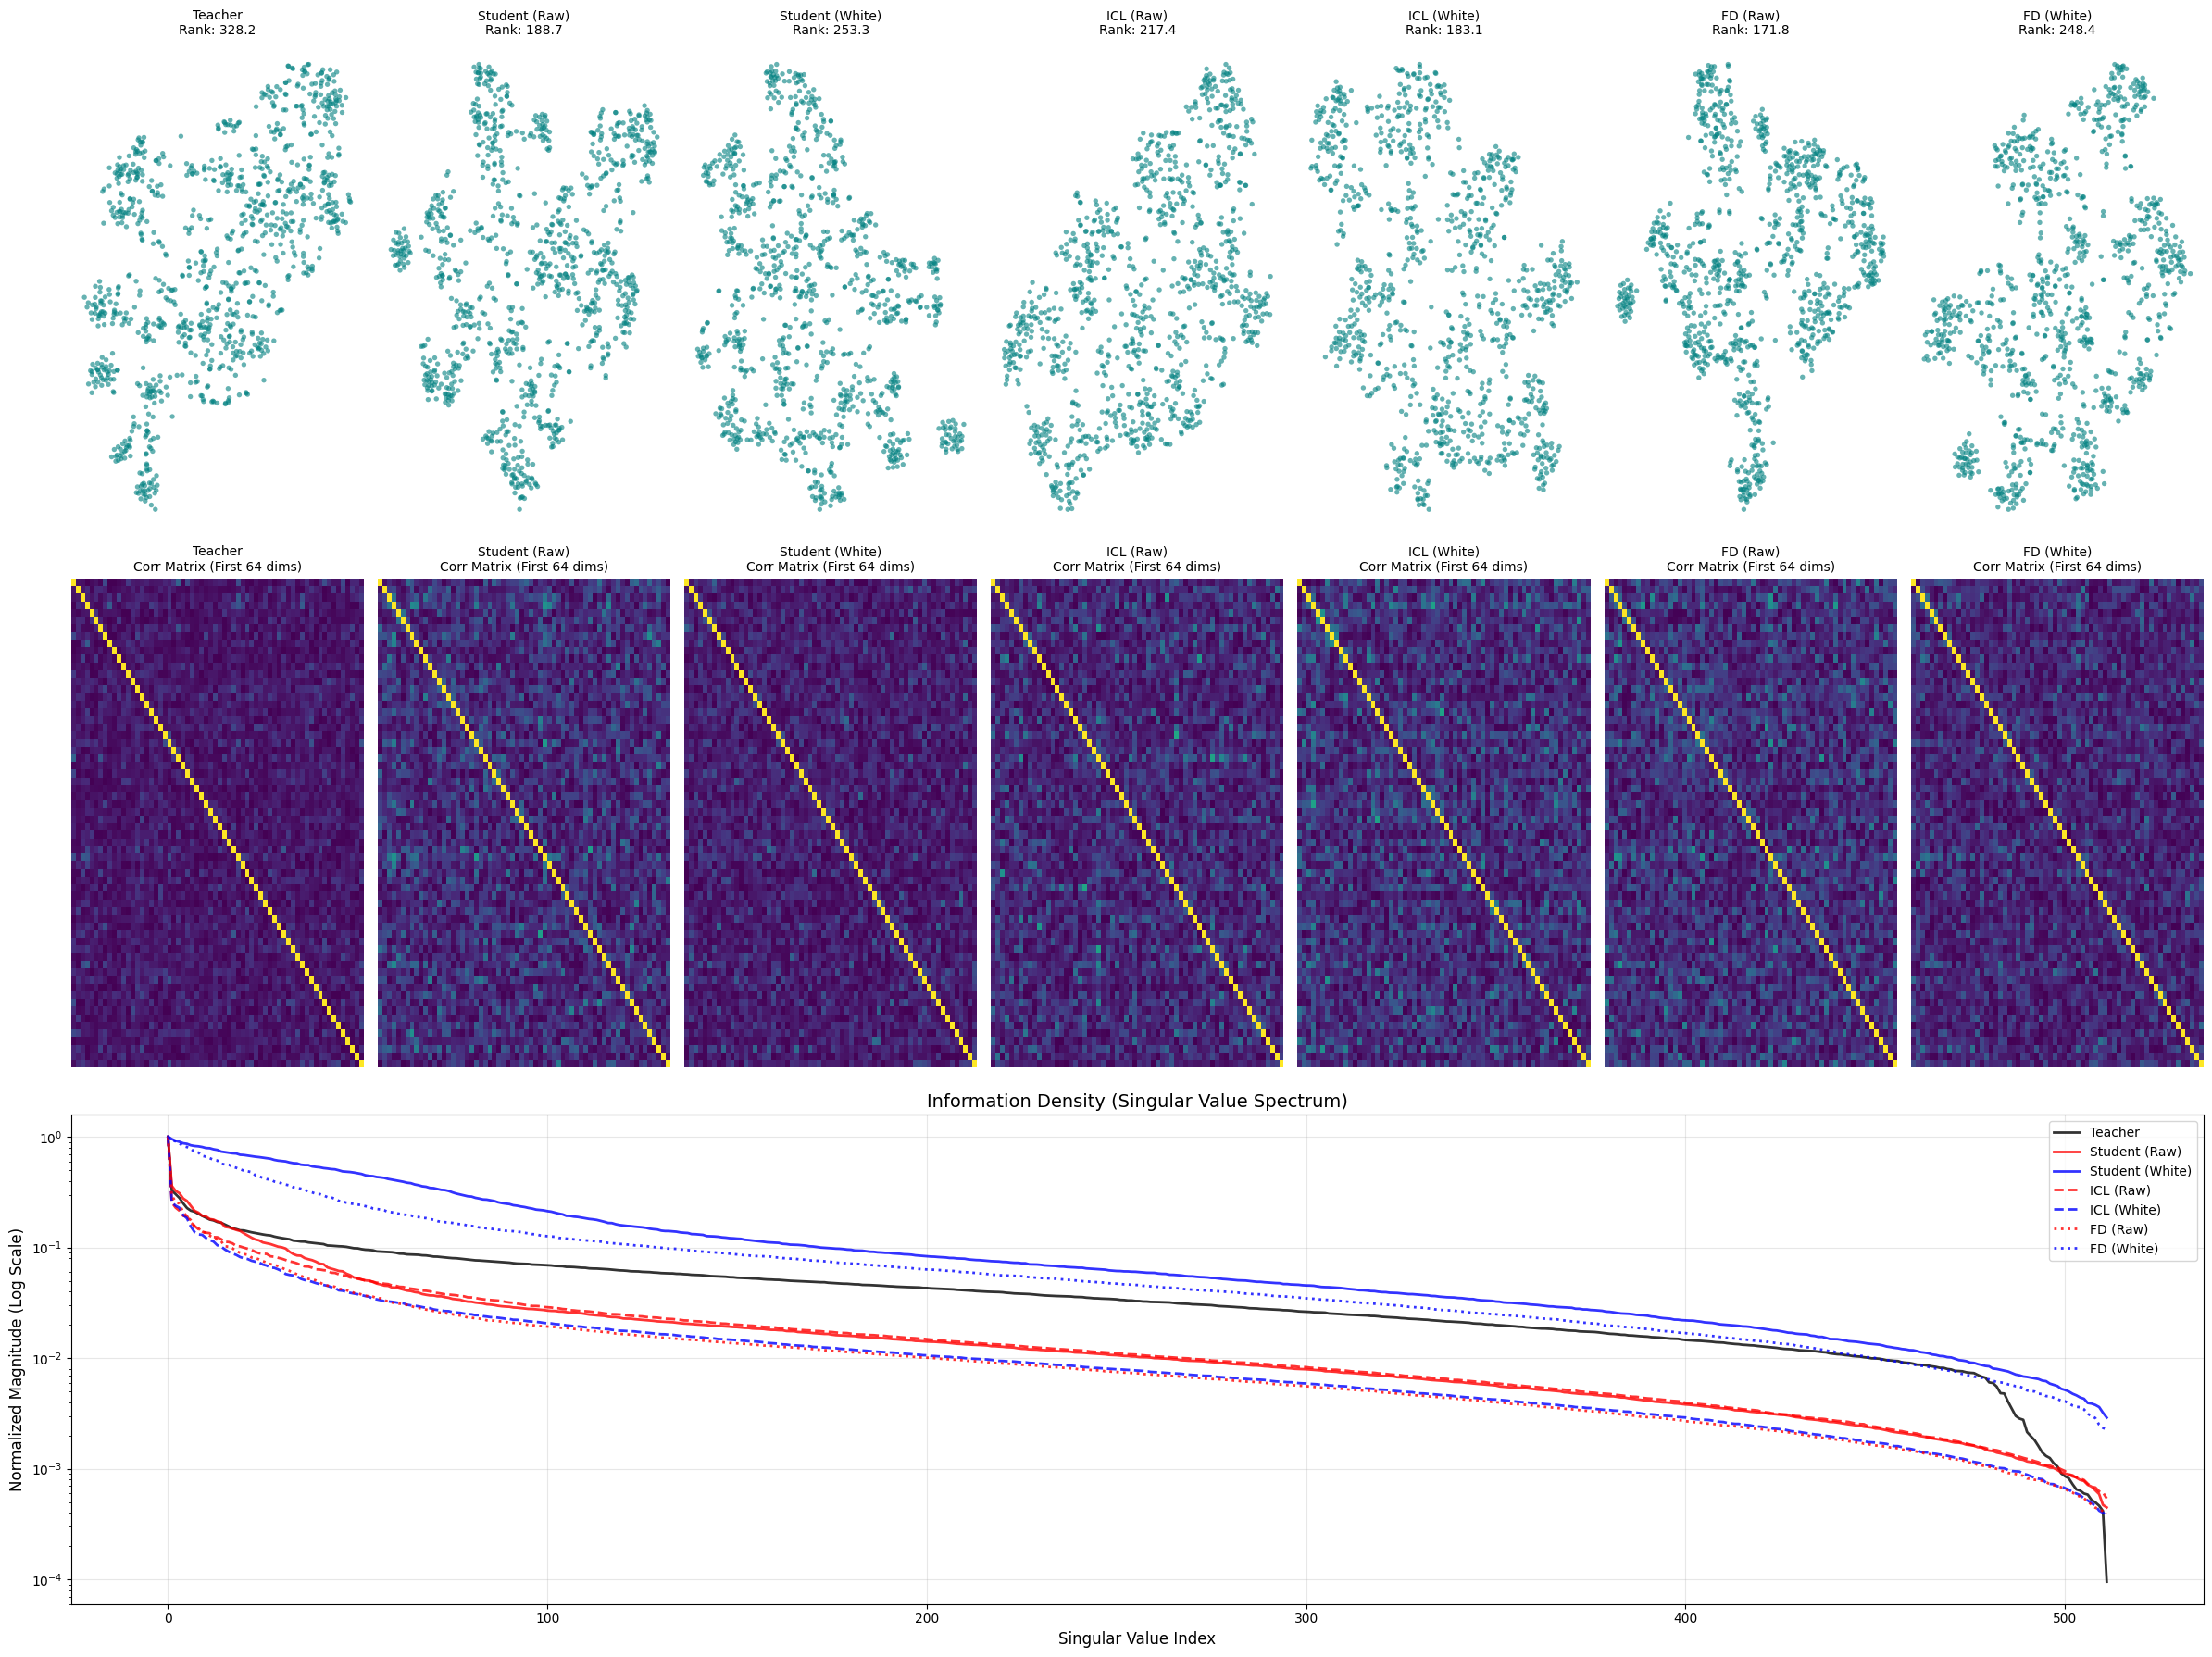

✅ Visualization Complete.


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch.utils.data import Subset
import seaborn as sns

# --- 1. CONFIGURATION ---
NUM_SAMPLES = 1000
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Define Model Registry
models_dict = {
    "Teacher": teacher,
    "Student (Raw)": student,
    "Student (White)": student_white,
    "ICL (Raw)": raw_icl,
    "ICL (White)": icl_white,
    "FD (Raw)": raw_fd,
    "FD (White)": fd_white
}

# --- 2. PREPARE FIXED DATASET ---
print(f"🎲 Sampling {NUM_SAMPLES} random datapoints for fair comparison...")

# Collect random indices
indices = torch.randperm(len(student_loader.dataset))[:NUM_SAMPLES]
subset = Subset(student_loader.dataset, indices)
eval_loader = torch.utils.data.DataLoader(subset, batch_size=256, shuffle=False)

# Pre-Compute Teacher Ground Truth
teacher_img_gt = []
with torch.no_grad():
    for imgs, tokens, t_img, t_txt in eval_loader:
        teacher_img_gt.append(t_img.to(DEVICE))
teacher_img_gt = torch.cat(teacher_img_gt)

# --- 3. METRIC FUNCTIONS ---
def compute_effective_rank(features):
    features = F.normalize(features, p=2, dim=-1)
    _, S, _ = torch.linalg.svd(features)
    p = S / S.sum()
    entropy = -torch.sum(p * torch.log(p + 1e-6))
    return torch.exp(entropy).item()

def compute_modal_gap(img_feats, txt_feats):
    img_center = img_feats.mean(dim=0)
    txt_center = txt_feats.mean(dim=0)
    return torch.norm(img_center - txt_center, p=2).item()

def compute_ts_distance(s_feats, t_feats):
    s_norm = F.normalize(s_feats, p=2, dim=-1)
    t_norm = F.normalize(t_feats, p=2, dim=-1)
    return F.mse_loss(s_norm, t_norm).item()

# --- 4. MAIN EVALUATION LOOP ---
results = []
feature_bank = {} # Store Image features for visualization

print("\n🚀 Running Full Evaluation Suite...")

for name, model in models_dict.items():
    print(f"   > Evaluating: {name}...")

    # A. Accuracy
    if name == "Teacher":
        acc = 0.0
    else:
        acc = evaluate_on_cifar(model, cifar_loader, DEVICE)

    # B. Extract Features
    model.eval()
    all_v = []
    all_t = []

    with torch.no_grad():
        for imgs, tokens, _, _ in eval_loader:
            imgs, tokens = imgs.to(DEVICE), tokens.to(DEVICE)
            if name == "Teacher":
                v = model.encode_image(imgs)
                t = model.encode_text(tokens)
            else:
                v, t, _ = model(imgs, tokens)
            all_v.append(v)
            all_t.append(t)

    all_v = torch.cat(all_v)
    all_t = torch.cat(all_t)

    # Normalize for Fairness in stats
    all_v_norm = F.normalize(all_v, p=2, dim=-1)
    all_t_norm = F.normalize(all_t, p=2, dim=-1)

    # Store for Plots
    feature_bank[name] = all_v_norm.cpu()

    # C. Compute Metrics
    rank_v = compute_effective_rank(all_v)
    rank_t = compute_effective_rank(all_t)
    gap = compute_modal_gap(all_v_norm, all_t_norm)

    if name == "Teacher":
        dist = 0.0
    else:
        dist = compute_ts_distance(all_v, teacher_img_gt)

    results.append({
        "Model": name,
        "CIFAR Acc": acc,
        "Rank (Img)": rank_v,
        "Modal Gap": gap,
        "Drift": dist
    })

# --- 5. PRINT TABLE ---
df = pd.DataFrame(results)
print("\n📊 FINAL REPORT CARD:")
print(df.round(4).to_string(index=False))

# --- 6. VISUALIZATION DASHBOARD ---
print("\n🎨 Generating Dashboard (t-SNE + Correlation + Spectrum)...")

# Setup Figure: 3 Rows (t-SNE, Heatmap, Spectrum)
fig = plt.figure(figsize=(24, 18))
gs = fig.add_gridspec(3, 7) # Grid for flexible layout

# A. t-SNE PLOTS (Top Row)
print("   ... Computing t-SNE")
for i, (name, feats) in enumerate(feature_bank.items()):
    ax = fig.add_subplot(gs[0, i])

    # Reduce dimensionality
    tsne = TSNE(n_components=2, perplexity=30, init='pca', learning_rate='auto')
    proj = tsne.fit_transform(feats.numpy())

    ax.scatter(proj[:, 0], proj[:, 1], alpha=0.6, s=15, c='teal', edgecolors='none')
    ax.set_title(f"{name}\nRank: {df.loc[df['Model']==name, 'Rank (Img)'].values[0]:.1f}", fontsize=10)
    ax.axis('off')

# B. CORRELATION HEATMAPS (Middle Row)
# We only plot the top 64x64 feature correlations to keep it readable,
# or the full matrix if you want to see the global sparsity.
print("   ... Computing Correlations")
for i, (name, feats) in enumerate(feature_bank.items()):
    ax = fig.add_subplot(gs[1, i])

    # Compute Correlation Matrix of Features (DxD)
    # feats is (N, D). Transpose to get (D, N) for feature correlations
    corr_matrix = torch.corrcoef(feats.T).abs().numpy()

    # Plot heatmap (subset 50x50 for visibility of diagonal pattern)
    sns.heatmap(corr_matrix[:64, :64], ax=ax, cmap="viridis", cbar=False, vmin=0, vmax=1)

    ax.set_title(f"{name}\nCorr Matrix (First 64 dims)", fontsize=10)
    ax.axis('off')

# C. SPECTRAL DENSITY / INFO DENSITY PLOT (Bottom Row - Large)
print("   ... Computing Spectral Density")
ax_spec = fig.add_subplot(gs[2, :]) # Spans entire bottom row

# Colors for groups
colors = {'Teacher': 'black', 'Raw': 'red', 'White': 'blue'}
styles = {'Teacher': '-', 'Student': '-', 'ICL': '--', 'FD': ':'}

for name, feats in feature_bank.items():
    # Singular Value Decomposition
    _, S, _ = torch.linalg.svd(feats)
    S = S / S.max() # Normalize max to 1 for fair comparison

    # Determine Style
    c = 'gray'
    if "Teacher" in name: c = colors['Teacher']
    elif "Raw" in name: c = colors['Raw']
    elif "White" in name: c = colors['White']

    ls = '-'
    if "ICL" in name: ls = styles['ICL']
    elif "FD" in name: ls = styles['FD']

    # Plot Spectrum (Log scale y is best for checking collapse)
    ax_spec.plot(S.numpy(), label=f"{name}", color=c, linestyle=ls, linewidth=2, alpha=0.8)



ax_spec.set_yscale('log')
ax_spec.set_title("Information Density (Singular Value Spectrum)", fontsize=14)
ax_spec.set_xlabel("Singular Value Index", fontsize=12)
ax_spec.set_ylabel("Normalized Magnitude (Log Scale)", fontsize=12)
ax_spec.legend()
ax_spec.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print("✅ Visualization Complete.")